In [8]:
%matplotlib inline

import os
import sys
import copy
import random
import tqdm.notebook as tq

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =',device)

device = cpu


In [2]:
def image_properties(img):
    '''
    Print image file properties
    '''
    print('image type:', type(img))
    print('image mode:', img.mode)
    print('image info:', img.info)
    array = np.array(img)
    print('image shape:', array.shape)
    print('min:', array.min(),'std:', array.std(),'mean:', array.mean(), 'max:',  array.max())
    print('array:', array)    

# Better to convert mask images from L mode to P (palette) mode to view the mask images nicely 
def palette():
    '''
    Returns palette (used in 'P' mode of image representation)
    '''
    colors_dict = {
        0: [0, 0, 0],       # 0 = background: black
        1: [255, 0, 0],     # 1 = seep class 1: red
        2: [255, 127, 0],   # 2: orange 
        3: [255, 255, 0],   # 3: yellow
        4: [0, 255, 0],     # 4: green
        5: [0, 0, 255],     # 5: blue
        6: [46, 43, 95],    # 6: dark blue
        7: [139, 0, 255],   # 7: purple
        }
    palette = []
    for i in np.arange(256):
        if i in colors_dict:
            palette.extend(colors_dict[i])
        else:
            palette.extend([0, 0, 0])
    return palette

def mask2p(msk):
    """
    Converts mask to P-mode image
    """
    msk=msk.convert('P')
    msk.putpalette(palette())
    return msk

def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (C,H,W) where the 0 dim is a C-one-hot encoding vector
    Where K - number of classes
    """
    classes = [0,1,2,3,4,5,6,7] # Classes in the dataset

    mask = np.asanyarray(mask)
    _mask = [mask == i for i in classes]
    return np.array(_mask).astype(np.uint8)

def onehot2mask(onehot):
    """
    Converts onehot representation (C, H, W) to mask representation (H,W)
    """
    array = np.argmax(onehot, axis=0).astype(np.uint8)
    return Image.fromarray(array, 'L')

def onehot2p(onehot):
    """
    Converts onehot representation (C, H, W) to P image mask representation (H,W)
    """
    array = np.argmax(onehot, axis=0).astype(np.uint8)
    img = Image.fromarray(array, 'P')
    img.putpalette(palette())
    return img

def preview(images):
    '''
    Preview images stacked horizontally
    '''
    fig, axs = plt.subplots(1, len(images), figsize=(10,10))
    for i, image in enumerate(images):
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

#def hstack_images(images):
#    """
#    horizontally stack images
#    """
#    def fig2img(figure):
#        """
#        Convert pyplot figure to PIL image from buffer
#        """
#        import io
#        buf = io.BytesIO()
#        figure.savefig(buf)
#        buf.seek(0)
#        return Image.open(buf)

#    fig, axs = plt.subplots(1, len(images))
#    for i, image in enumerate(images):
#        axs[i].imshow(image)
#        axs[i].axis('off')
#    
#    return fig2img(fig)

# def preview_tensor(tensor):
#     '''
#     plots image tensor

#     '''
#     plt.imshow(tensor.permute(1, 2, 0))
#     plt.show()

## Check that conversions work fine
# msk = msk_files[0]
# msk = Image.open(msk)
# print(msk.size)

# onehotmsk = mask2onehot(msk)
# print(onehotmsk.shape)

# msk = onehot2mask(onehotmsk)
# print(msk.size)
# msk = mask2p(msk)
# msk

# Lets see the class distribution in the dataset
def class_distribution(filenames, show=False):
    all = []
    for msk in filenames:
        msk = Image.open(msk)
        array = np.array(msk)
        all.append(array)
    all = np.array(all)
    all.flatten()
    counts = np.unique(all, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])
    if show:
        plt.bar(counts[0][1:], counts[1][1:]) # dont show class 0 - background
        plt.show()

# Load Data

In [3]:
# Initial files are in 'input' directory
img_dir = 'input/train_images_256'
mask_dir = 'input/train_masks_256'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(img_dir) for name in files]

msk_files = [os.path.join(path, name) for path, subdirs, files in os.walk(mask_dir) for name in files]

print('Image files: ', len(img_files))
print('First 5 file names:', img_files[0:5])
print()
print('Mask files: ', len(msk_files))
print('First 5 file names:', msk_files[0:5])

Image files:  790
First 5 file names: ['input/train_images_256\\041869.000003.tif', 'input/train_images_256\\041869.000004.tif', 'input/train_images_256\\041869.000005.tif', 'input/train_images_256\\041869.000007.tif', 'input/train_images_256\\041869.000023.tif']

Mask files:  790
First 5 file names: ['input/train_masks_256\\041869.000003.tif', 'input/train_masks_256\\041869.000004.tif', 'input/train_masks_256\\041869.000005.tif', 'input/train_masks_256\\041869.000007.tif', 'input/train_masks_256\\041869.000023.tif']


image type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
image mode: I;16
image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}
image shape: (256, 256)
min: 8853 std: 5060.030253406354 mean: 24976.518798828125 max: 53470
array: [[24788 18060 17351 ... 37890 18768 16997]
 [23017 19122 23017 ... 23371 22663 25850]
 [26558 27621 26912 ... 17705 21247 22309]
 ...
 [30099 25142 26558 ... 15581 20538 25496]
 [20538 27266 23725 ... 20184 18414 33640]
 [23017 18414 22663 ... 22309 25850 28329]]


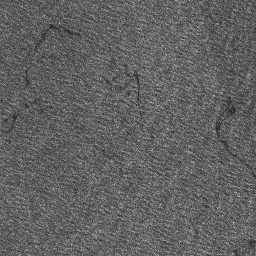

In [36]:
# image file
img = Image.open(img_files[8])
image_properties(img)
# I;16 mode = 16-bit unsigned integer pixels
img

In [47]:
def mask2onehot(mask):
    """
    Converts a segmentation mask (H,W) to (C,H,W) where the 0 dim is a C-one-hot encoding vector
    Where K - number of classes
    """
    classes = [0,1,2,3,4,5,6,7] # Classes in the dataset

    mask = np.asanyarray(mask)
    
    #_mask = [mask == i for i in classes]
    #mask = np.array(_mask).astype(np.uint8)
    
    mask = np.where(mask == 0, 0, 1)
    return mask


# mask file
msk = Image.open(msk_files[8])
#image_properties(msk)
# L mode = 8-bit pixels, black and white
counts = np.unique(msk, return_counts = True)
print(counts)
msk=mask2onehot(msk)
counts0 = np.unique(msk, return_counts = True)
print(counts0)

(array([0, 1, 2, 3, 6], dtype=uint8), array([63021,  1523,   269,   610,   113], dtype=int64))
(array([0, 1]), array([63021,  2515], dtype=int64))


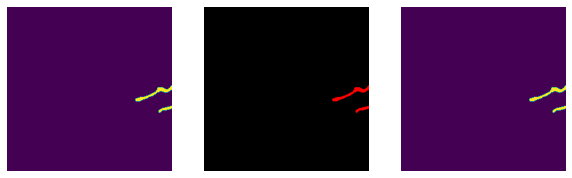

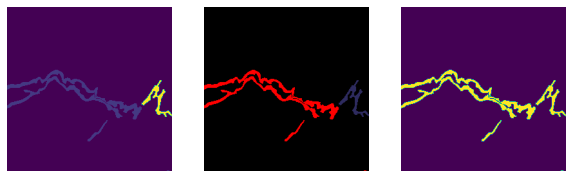

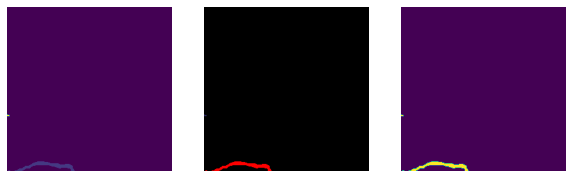

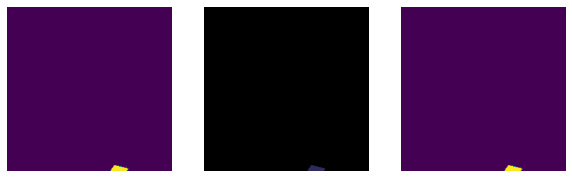

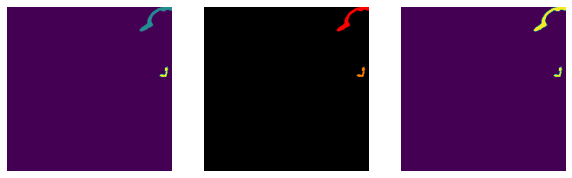

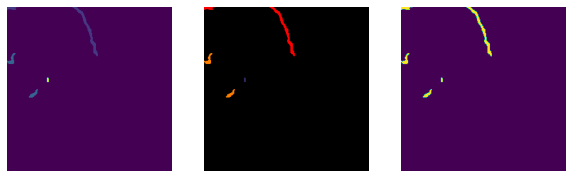

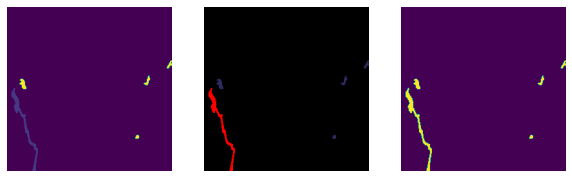

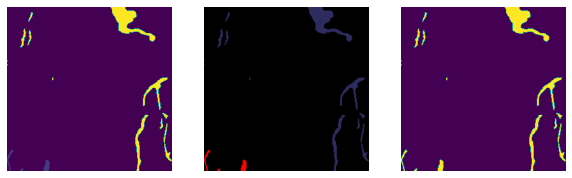

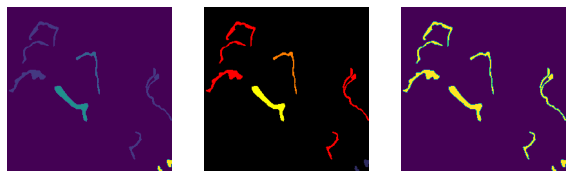

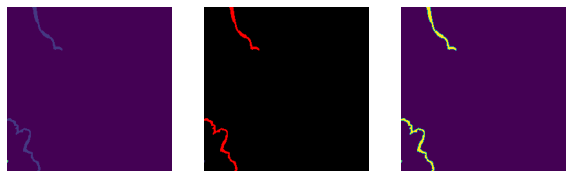

In [52]:
n_preview = 10
for i in range(n_preview):
    img = img_files[i]
    msk = msk_files[i]
    img = Image.open(img)
    msk = Image.open(msk)
    mskp = mask2p(msk)
    onehot = mask2onehot(msk)

    preview((msk, mskp, onehot))

    #invonehot = onehot2mask(onehot)
    #invonehotp = onehot2p(onehot)
    #preview((img, msk, mskp, invonehot, invonehotp))

# Train/Test Split

In [7]:
imgs_train, imgs_val, msks_train, msks_val = \
    train_test_split(img_files, msk_files, test_size=0.2, shuffle=True, random_state=42)
print(len(imgs_train), len(imgs_val))

632 158


# Make Dataset

classes: [0 1 2 3 4 5 6 7]
counts: [40690601   415838    49554    16727    36336   111524    93726     4446]


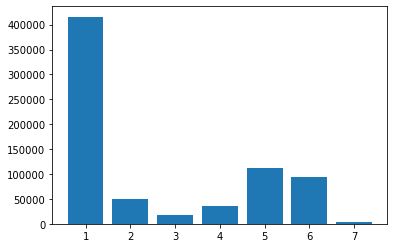

classes: [0 1 2 3 4 5 6 7]
counts: [40690601   415838    49554    16727    36336   111524    93726     4446]


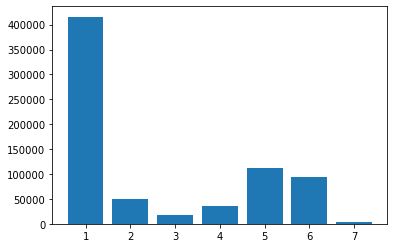

classes: [0 1 2 3 4 5 6 7]
counts: [10147887   109497    15204     5762     6621    43667    22503     3547]


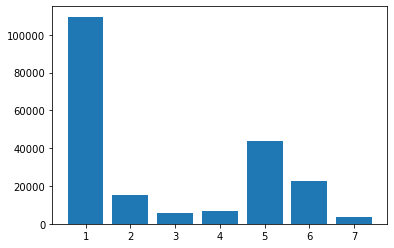

In [8]:
class_distribution(msks_train, show=True)
# The problem is quite imbalanced with class 1 - 65 times more represented then class 7

class_distribution(msks_train, show=True)
class_distribution(msks_val, show=True)
# Val set distribution is slightly different from train test split - possibly needs improvement 

In [9]:
# Images need to be normalized , find normalization parameters:
lst = []
for image in imgs_train:
    image = Image.open(image)
    array = np.array(image)
    lst.append(array)
MU = np.mean(lst)
STD = np.std(lst)    
print('mean:', MU, 'std:', STD, 'min:', np.min(lst), 'max:', np.max(lst))

mean: 28903.821916556055 std: 11003.210336028298 min: 0 max: 65535


In [10]:
def normalize(im):
    im = np.array(im)
    im = (im - MU)/STD
    return im

def inv_normalize(im):
    #im = im.numpy()
    im = np.squeeze(im)
    im = im * STD + MU
    im = im.astype('uint16')
    im = Image.fromarray(im, 'I;16')
    return im

In [11]:
class SeepDataset(Dataset):
    def __init__(self, image_paths, target_paths, augment):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.augment = augment

    def transform(self, image, mask, augment):
        if augment:
            # Random rotate
            rotate = transforms.RandomRotation(180)
            angle = rotate.get_params(rotate.degrees)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

        image = normalize(image)
        image = TF.to_tensor(image)

        mask = mask2onehot(mask)
        mask = TF.to_tensor(mask)
        mask = mask.permute(1, 2, 0)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask, augment=self.augment)
        return x, y

    def __len__(self):
        return len(self.image_paths)


train_dataset = SeepDataset(imgs_train, msks_train, augment=True)
val_dataset = SeepDataset(imgs_val, msks_val, augment=False)

<class 'torch.Tensor'> torch.Size([1, 256, 256]) <class 'torch.Tensor'> torch.Size([8, 256, 256])
(8, 256, 256)
-2.626853530366042 1.9729858305408035 1.1671572605667884 -1.6110662685484236


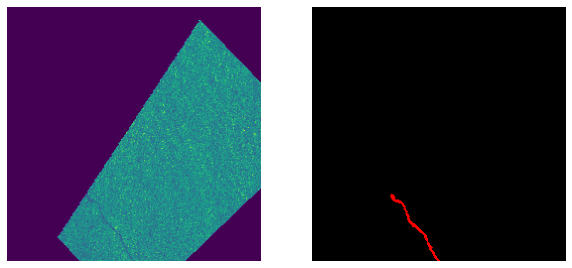

In [12]:
# Check dataloaders
iterator_train = iter(train_dataset)
iterator_val = iter(val_dataset)

image, onehot = next(iterator_train)
print(type(image), image.shape, type(onehot), onehot.shape)
image = image.numpy()
onehot = onehot.numpy()
print(onehot.shape)
print(image.min(), image.max(), image.std(), image.mean())

image = inv_normalize(image)
mask = onehot2p(onehot)
preview((image, mask))

In [13]:
BATCH_SIZE = 16
dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('n_batches_train:', len(dataloader_train), 'n_batches_val:', len(dataloader_val))

n_batches_train: 40 n_batches_val: 10


## Model

In [14]:
from segmentation_models import UNet, ResNetUNet
model = UNet(8, 1)
#model = ResNetUNet(8)
model=model.to(device)
summary(model, input_size=(1, 256, 256)) # input size required to do the forward pass throught the model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [7]:
from segmentation_models import UNet, ResNetUNet
#model = UNet(8, 1)
model = ResNetUNet(7)
model=model.to(device)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

## Loss

In [10]:
from segmentation_loss import DiceLoss, DiceBCELoss, FocalTverskyLoss, BCELoss

## Train Function

In [16]:
def train(model, optimizer, scheduler, loss_fn, num_epochs=1):

    #Check device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device =',device)
    model=model.to(device)

    # Instantiate SummaryWriter
    writer = SummaryWriter()
    
    #Initialize some variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    lr = 0 #required so that learning rate prints first time   
    
    total_train_samples = 0
    total_test_samples = 0   
    
    # Iterate over epochs
    for epoch in tq.tqdm(range(num_epochs)):

        # print learning rate if it was changed in this epoch
        if lr != optimizer.param_groups[0]['lr']:
            lr = optimizer.param_groups[0]['lr']
            print("epoch =", epoch, "; learning rate =", lr)
        
        #Train      
        model.train()
        torch.set_grad_enabled(True)
       
        for imgs, msks in dataloader_train:
            
            imgs = imgs.to(device, dtype=torch.float32)    
            msks = msks.to(device, dtype=torch.float32)
            
            batch_size = imgs.size(0)
            total_train_samples += batch_size

            optimizer.zero_grad()
            msks_pred = model(imgs)            
            loss = loss_fn(msks_pred, msks)
            
            writer.add_scalar('train_loss', loss, total_train_samples)
            
            loss.backward()            
            optimizer.step()            
       
        #Eval  
        if epoch % 1 == 0: # evaluate results for epochs ## n , e.g: 0, 10, 20...
            
            model.eval()
            torch.set_grad_enabled(False)
            
            epoch_samples = 0
            epoch_loss = 0
            
            for imgs, msks in dataloader_val:
                
                imgs = imgs.to(device, dtype=torch.float32)
                msks = msks.to(device, dtype=torch.float32)
                
                batch_size = imgs.size(0)
                epoch_samples+=batch_size
                total_test_samples+=batch_size

                msks_pred = model(imgs)             
                loss = loss_fn(msks_pred, msks)
                
                epoch_loss += loss
                writer.add_scalar('val_loss', loss, total_test_samples)            
            
            #Save best model
            avg_epoch_loss = epoch_loss/epoch_samples
            if avg_epoch_loss < best_loss:
                #print("saving best model")
                best_loss = avg_epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'current_best_model_state_dict.pth')
       
        #Step for learning rate scheduler
        scheduler.step()
    
    # Close SummaryWriter
    writer.close()
    
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

## Initialize Model Weights

In [17]:
# UNET
# https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/24
# https://pytorch.org/docs/stable/nn.init.html
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(m.bias)

model=model.to(device)

model.apply(weights_init)
#model.load_state_dict(torch.load('current_best_model_state_dict.pth', map_location=torch.device('cpu')))
print()

## Train

In [18]:
%%time

#%load_ext tensorboard
# !rm -rf runs # clean any previous data from tensorboard
#%tensorboard --logdir runs --host=127.0.0.1

optimizer = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

loss = DiceLoss()
#loss = DiceBCELoss(bce_weight=0.5)
#loss = FocalTverskyLoss(alpha = 0.7, beta = 0.3, gamma = 1.33)

model=train(model=model, optimizer=optimizer, scheduler=exp_lr_scheduler, loss_fn=loss,  num_epochs=1)

device = cpu


  0%|          | 0/1 [00:00<?, ?it/s]

epoch = 0 ; learning rate = 0.0001


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), 'model_state_dict.pth')
#from google.colab import files
#files.download("model_state_dict.pth")

## Preview Results

In [ ]:
def distr(msk):
    array = np.array(msk)
    counts = np.unique(array, return_counts = True)
    print('classes:', counts[0])
    print('counts:', counts[1])

In [ ]:
# Preview images masks and predictions from validation set
images, masks = next(iter(dataloader_val))

images = images.to(device)
model.eval()
torch.set_grad_enabled(False)
preds = model(images.float())

images = images.data.cpu().numpy()
masks = masks.data.cpu().numpy()
preds = preds.data.cpu().numpy()

print(images.shape, masks.shape, preds.shape)

for i in range(images.shape[0]):
    image = images[i,:,:,:]
    mask = masks[i,:,:,:]
    pred = preds[i,:,:,:]

    image = inv_normalize(image)

    mask = onehot2mask(mask)
    print('mask:')
    distr(mask)

    pred = onehot2mask(pred)
    print('pred:')
    distr(pred)

    preview((image, mask2p(mask), mask2p(pred)))